In [1]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares

In [2]:
input_file_name = 'Run1_list.txt'
output_file_name = 'Run1_list.pickle'
boards = 3

In [3]:
Tstamp_us = []
Brd = []
Ch = []
LG = []
HG = []
runNum = []

file_start_time = 0

for run_number in range(1, 2):
    #input_file_name = f"Long_Run/Run{run_number}_list.txt"
    input_file_name = f"Run1_list.txt"
    with open(input_file_name) as f:
        lines = f.read().split('\n')

    last_tstamp = 0  # Initialize last timestamp for continuity across files

    for i, line in enumerate(lines):
        if i > 8:
            data = line.split()

            if len(data) == 6:
                Tstamp_us.append(float(data[0]) + file_start_time)
                last_tstamp = float(data[0]) + file_start_time
                Brd.append(int(data[2]))
                Ch.append(int(data[3]))
                LG.append(int(data[4]))
                HG.append(int(data[5]))
                runNum.append(run_number)
            elif len(data) == 4:
                if last_tstamp is not None:
                    Tstamp_us.append(last_tstamp)
                Brd.append(int(data[0]))
                Ch.append(int(data[1]))
                LG.append(int(data[2]))
                HG.append(int(data[3]))
                runNum.append(run_number)
    file_start_time =+ last_tstamp


In [4]:
window_size = 100
current_event_id = 1
current_timestamp = Tstamp_us[0]
event_ids = []
for timestamp in Tstamp_us:
    if timestamp - current_timestamp <= window_size:
        event_ids.append(current_event_id)
    else:
        current_event_id += 1
        event_ids.append(current_event_id)
        current_timestamp = timestamp
        
event_counts = Counter(event_ids)
mask = [event_counts[event_id] == (boards*64) for event_id in event_ids]

In [5]:
Brd = [value for i, value in enumerate(Brd) if mask[i]]
Ch = [value for i, value in enumerate(Ch) if mask[i]]
LG = [value for i, value in enumerate(LG) if mask[i]]
HG = [value for i, value in enumerate(HG) if mask[i]]
Tstamp_us = [value for i, value in enumerate(Tstamp_us) if mask[i]]
event_ids = [value for i, value in enumerate(event_ids) if mask[i]]

In [6]:
def getlayerquad(brd, ch):
    channel_number = (brd*64) + ch
    
    if channel_number < (4*4*7):
        quadrant = (channel_number // 7) % 4  
        layer = (channel_number // (7*4))+1
        brdch = channel_number % 7

    elif channel_number >= (4*4*7) and channel_number < (4*4*7)+(4*4*4):
        quadrant = ((channel_number-(4*4*7)) // 4) % 4
        layer = 5 + (channel_number-(4*4*7)) // (4*4)
        brdch = (channel_number - (4*4*7)) % 4
        
    elif channel_number >= (4*4*7)+(4*4*4) & channel_number < (4*4*7)+(4*4*4)+(4*3*4):
        quadrant = (((channel_number - ((4*4*7)+(4*4*4))) // 4) % 3)+1
        layer = 9 + (channel_number-((4*4*7)+(4*4*4))) // (4*3)
        brdch = (channel_number - (4*4*7)+(4*4*4)) % 4
        
    else:
        quadrant = (((channel_number - ((4*4*7)+(4*4*4)+(4*3*4))) // 4) % 3)
        layer = 11 + (channel_number-((4*4*7)+(4*4*4)+(4*3*4))) // (4*4)
        brdch = (channel_number - (4*4*7)+(4*4*4)+(4*3*4)) % 4
        
    return layer, quadrant, brdch

def getbrdxy(chs, brdch):
    #position of channel relative to lower right corner of the board
    if chs == 4:
        if brdch == 0:
            return (73.9, 72.89)
        if brdch == 1:
            return (26.1, 72.89)
        if brdch == 2:
            return (73.9, 25.09)
        if brdch == 3:
            return (26.1, 25.09)
        return None
    if brdch == 0:
        return (50.01, 80.9)
    if brdch == 1:
        return (77.64, 64.95)
    if brdch == 2:
        return (22.37, 64.95)
    if brdch == 3:
        return (50.01, 48.99)
    if brdch == 4:
        return (77.64, 33.04)
    if brdch == 5:
        return (22.37, 33.04)
    if brdch == 6:
        return (50.01, 17.08)

def getxyz(brd, ch):
    layer, quadrant, brdch = getlayerquad(brd, ch)

    chs = -1
    x = 0
    y = 0
    z = 0
    if layer < 5:
        chs = 7
    else:
        chs = 4
    brdx, brdy = getbrdxy(chs, brdch)
    
    if quadrant == 0:
        x = brdx
        y = 99.27 - brdy
    elif quadrant == 1:
        x = -1 * brdx
        y = 1.27 + brdy
    elif quadrant == 2:
        x = -1 * brdx
        y = -99.27 + brdy
    elif quadrant == 3:
        x = brdx
        y = -1.27 - brdy
        
    z = 24.0526 + ((layer-1)*27.1526)
    
    return x, y, z
        

In [7]:
xpos = []
ypos = []
zpos = []
# Iterate over Brd and Ch simultaneously and apply getxyz function
for brd_val, ch_val in zip(Brd, Ch):
    x, y, z = getxyz(brd_val, ch_val)
    xpos.append(x)
    ypos.append(y)
    zpos.append(z)

In [8]:
events = pd.DataFrame({
    'Brd': Brd,
    'Ch': Ch,
    'LG': LG,
    'HG': HG,
    'Tstamp_us': Tstamp_us,
    'event_ids': event_ids,
    'xpos': xpos,
    'ypos': ypos,
    'zpos': zpos
})

In [9]:
with open(output_file_name, 'wb') as handle:
    pickle.dump(events, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# Get unique event IDs and their indices
unique_event_ids, event_indices = np.unique(event_ids, return_index=True)

# Calculate average Tstamp_us for each event ID
average_timestamps = []
for i, event_id in enumerate(unique_event_ids):
    # Calculate the range of indices for the current event ID
    start_index = event_indices[i]
    end_index = event_indices[i+1] if i < len(event_indices) - 1 else len(Tstamp_us)
    
    # Calculate average timestamp for the current event ID
    timestamps_for_event = Tstamp_us[start_index:end_index]
    average_timestamp = np.mean(timestamps_for_event)
    average_timestamps.append(average_timestamp)

65.77922112818001
0.13730273043317437


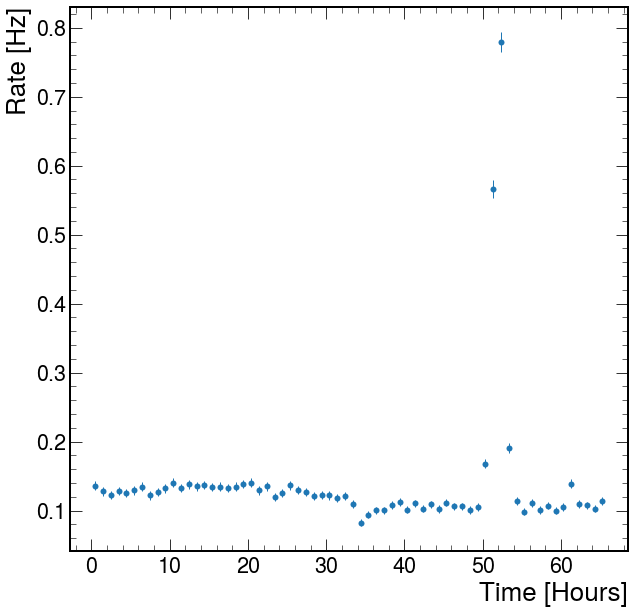

In [37]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

# Calculate the range of your data
data_range = max(average_timestamps) - min(average_timestamps)

# Calculate the number of bins needed to represent 1-hour intervals
num_hours = data_range / (60 * 60 * 1e6)  # Convert microseconds to hours
num_bins = int(np.ceil(num_hours))
print(num_hours)
print(len(average_timestamps) / (data_range / ( 1e6)))
# Calculate the bin edges
bin_edges = np.linspace(min(average_timestamps), max(average_timestamps), num_bins + 1)

# Compute histogram
h, bins = np.histogram(average_timestamps, bins=bin_edges)

bin_centers_us = 0.5 * (bins[:-1] + bins[1:])


# Convert bin centers to hours
bin_centers_hours = bin_centers_us / (60 * 60 * 1e6)  # Convert microseconds to hours

# Convert counts to rates (Hz)
bin_width_hours = (bins[1] - bins[0]) / (1e6)  # Convert microseconds to hours
h_rate = h / bin_width_hours

# Plot
plt.errorbar(bin_centers_hours, h_rate, yerr=np.sqrt(h)/bin_width_hours, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
#plt.ylim(0, 0.1)
plt.xlabel("Time [Hours]")
plt.ylabel("Rate [Hz]")
plt.show()



65.77922112818001
0.13730273043317437


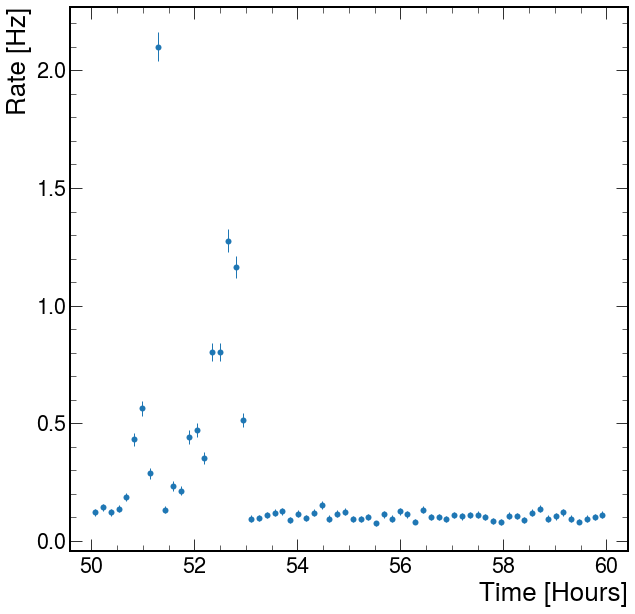

In [39]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

# Calculate the range of your data
data_range = max(average_timestamps) - min(average_timestamps)

# Calculate the number of bins needed to represent 1-hour intervals
num_hours = data_range / (60 * 60 * 1e6)  # Convert microseconds to hours
num_bins = int(np.ceil(num_hours))
print(num_hours)
print(len(average_timestamps) / (data_range / ( 1e6)))
# Calculate the bin edges
bin_edges = np.linspace(50 * (60 * 60 * 1e6), 60 * (60 * 60 * 1e6), num_bins + 1)

# Compute histogram
h, bins = np.histogram(average_timestamps, bins=bin_edges)

bin_centers_us = 0.5 * (bins[:-1] + bins[1:])


# Convert bin centers to hours
bin_centers_hours = bin_centers_us / (60 * 60 * 1e6)  # Convert microseconds to hours

# Convert counts to rates (Hz)
bin_width_hours = (bins[1] - bins[0]) / (1e6)  # Convert microseconds to hours
h_rate = h / bin_width_hours

# Plot
plt.errorbar(bin_centers_hours, h_rate, yerr=np.sqrt(h)/bin_width_hours, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
#plt.ylim(0, 0.1)
plt.xlabel("Time [Hours]")
plt.ylabel("Rate [Hz]")
plt.show()



In [12]:
def getlayerquad(brd, ch):
    channel_number = (brd*64) + ch
    
    if channel_number < (4*4*7):
        quadrant = (channel_number // 7) % 4  
        layer = (channel_number // (7*4))+1
        brdch = channel_number % 7

    elif channel_number >= (4*4*7) and channel_number < (4*4*7)+(4*4*4):
        quadrant = ((channel_number-(4*4*7)) // 4) % 4
        layer = 5 + (channel_number-(4*4*7)) // (4*4)
        brdch = (channel_number - (4*4*7)) % 4
        
    elif channel_number >= (4*4*7)+(4*4*4) & channel_number < (4*4*7)+(4*4*4)+(4*3*4):
        quadrant = (((channel_number - ((4*4*7)+(4*4*4))) // 4) % 3)+1
        layer = 9 + (channel_number-((4*4*7)+(4*4*4))) // (4*3)
        brdch = (channel_number - (4*4*7)+(4*4*4)) % 4
        
    else:
        quadrant = (((channel_number - ((4*4*7)+(4*4*4)+(4*3*4))) // 4) % 3)
        layer = 11 + (channel_number-((4*4*7)+(4*4*4)+(4*3*4))) // (4*4)
        brdch = (channel_number - (4*4*7)+(4*4*4)+(4*3*4)) % 4
        
    return layer, quadrant, brdch

        
print(getlayerquad(0,0))

    

(1, 0, 0)


Text(0.5, 0.92, 'Event 1')

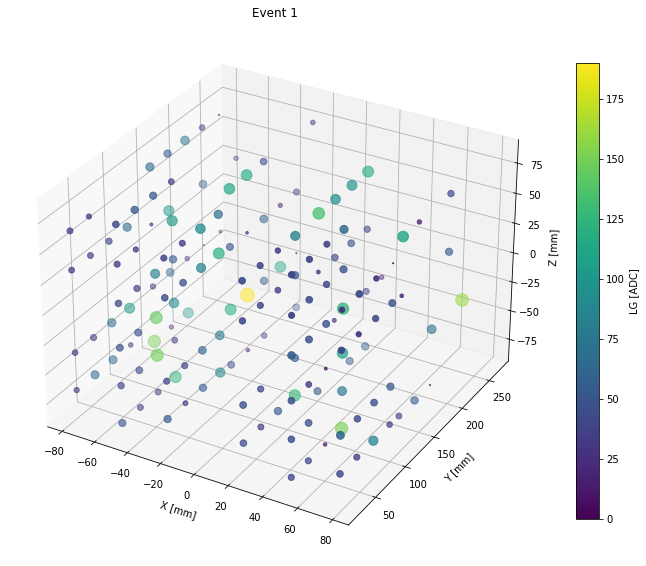

In [13]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
event_ids = np.array(event_ids)
mask = event_ids == 1
xpos = np.array(xpos)
ypos = np.array(ypos)
zpos = np.array(zpos)
LG = np.array(LG)

sc = ax.scatter(xpos[mask], zpos[mask], ypos[mask], s=LG[mask], c=LG[mask], cmap='viridis')
plt.colorbar(sc, label='LG [ADC]', shrink=0.7)
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_title("Event 1")

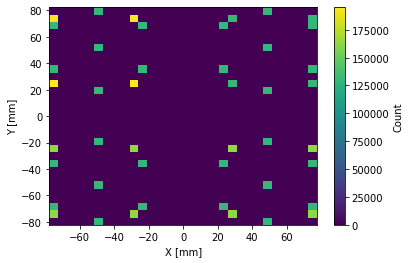

In [14]:
plt.hist2d(xpos, ypos, bins=30, cmap='viridis')
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.colorbar(label="Count")

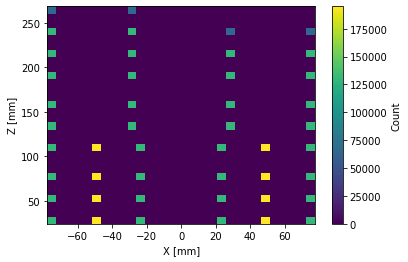

In [15]:
plt.hist2d(xpos, zpos, bins=30, cmap='viridis')
plt.xlabel("X [mm]")
plt.ylabel("Z [mm]")
plt.colorbar(label="Count")

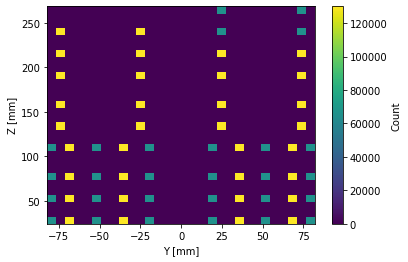

In [16]:
plt.hist2d(ypos, zpos, bins=30, cmap='viridis')
plt.xlabel("Y [mm]")
plt.ylabel("Z [mm]")
plt.colorbar(label="Count")

Text(0.5, 1.0, 'Summed raw event LG')

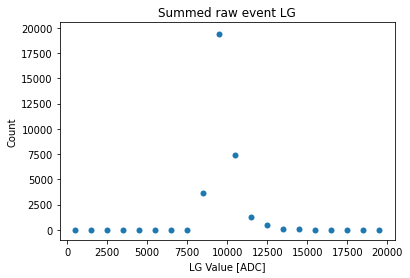

In [17]:
LG_event_sum_list = events.groupby('event_ids')['LG'].sum().tolist()

h, bins = np.histogram(LG_event_sum_list, bins=20, range=(0, 20000))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
plt.xlabel("LG Value [ADC]")
plt.ylabel("Count")
plt.title("Summed raw event LG")

In [18]:
def get_LG_values(board_number, channel_number, events):

    # Filter events DataFrame based on board number and channel number
    filtered_events = events[(events['Brd'] == board_number) & (events['Ch'] == channel_number)]
    
    # Retrieve LG values from filtered events
    LG_values = filtered_events['LG'].tolist()

    
    return LG_values

In [33]:
hep.style.use("CMS")

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def plot_histograms_ptrig(board_number, events):
    # Create subplots for each channel
    fig, axs = plt.subplots(8, 8, figsize=(16, 16))
    fig.suptitle(f'Board {board_number} - LG Histograms', fontsize=20, y = 1)
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    
    ptrigs = []
    ptrigmeans = []
    ptrigsigmas = []
    
    for i in range(8):
        for j in range(8):
            channel_number = i * 8 + j
            LG_values = get_LG_values(board_number, channel_number, events)
            
            # Create histogram
            h, bins = np.histogram(LG_values, bins=50, range=(0, 1005))
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            errors = np.sqrt(h)
            
            # Plot error bar plot
            axs[i, j].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
        
            axs[i, j].set_title(f'Channel {channel_number}', fontsize = 10, pad=-15, loc='center')
            
            initial_params = [max(h),50,20]
            mask = h > 0
            
            m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
            # Set limits for the sigma parameter
            m.limits["sigma"] = (0, None)
            # Perform the fit
            m.migrad()
            # Get the fitted parameters
            fitted_params = m.values
            A_fit = fitted_params['A']
            mu_fit = fitted_params['mu']
            sigma_fit = fitted_params['sigma']
            LG_values = np.array(LG_values)
            mask = LG_values < 400
            ptrigmeans.append(np.mean(LG_values[mask]))
            ptrigsigmas.append(sigma_fit)
    
            x = np.linspace(0, 100, 1000)
            y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
            
            x = np.linspace(0, 100, 1000)
            y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
            #axs[i, j].plot(x, y_fit, 'tab:orange', label='Fit')
            axs[i, j].set_yscale("log") 
            
            # Set labels
            if i == 7:  # Bottom most row
                axs[i, j].set_xlabel('LG Value [ADC]', fontsize = 10)
            if j == 0:  # Left most column
                axs[i, j].set_ylabel('Count', fontsize = 10)

    # Adjust layout   
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
 
    plt.show()
    ptrigs.append(ptrigmeans)
    ptrigs.append(ptrigsigmas)
    return ptrigs

In [20]:
def plot_histograms_pedsub(board_number, events, ptrigs):
    # Create subplots for each channel
    fig, axs = plt.subplots(8, 8, figsize=(16, 16),sharey=True,sharex=True)
    fig.suptitle(f'Board {board_number} - LG Histograms (Pedestal Subtracted)', fontsize=20, y = 1)
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    
    MIPs = []
    MIPMeans = []
    MIPSigmas = []
    
    for i in range(8):
        for j in range(8):
            channel_number = i * 8 + j
            LG_values = get_LG_values(board_number, channel_number, events)
            LG_values = np.array(LG_values)
            LG_values = LG_values[LG_values >= (ptrigs[1][channel_number] * 4)+ptrigs[0][channel_number]] - ptrigs[0][channel_number]
            
            MIPMeans.append(np.mean(LG_values))
            MIPSigmas.append(np.std(LG_values))
            
            # Create histogram
            h, bins = np.histogram(LG_values, bins=20, range=(0, 1005))
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            errors = np.sqrt(h)
            
            # Plot error bar plot
            axs[i, j].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
        
            axs[i, j].set_title(f'Channel {channel_number}', fontsize = 10, pad=-15, loc='center')
 
            
            #plt.yscale("log") 
            
            # Set labels
            if i == 7:  # Bottom most row
                axs[i, j].set_xlabel('LG Value [ADC]', fontsize = 10)
            if j == 0:  # Left most column
                axs[i, j].set_ylabel('Count', fontsize = 10)
    
    # Adjust layout   
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()
    MIPs.append(MIPMeans)
    MIPs.append(MIPSigmas)
    return MIPs


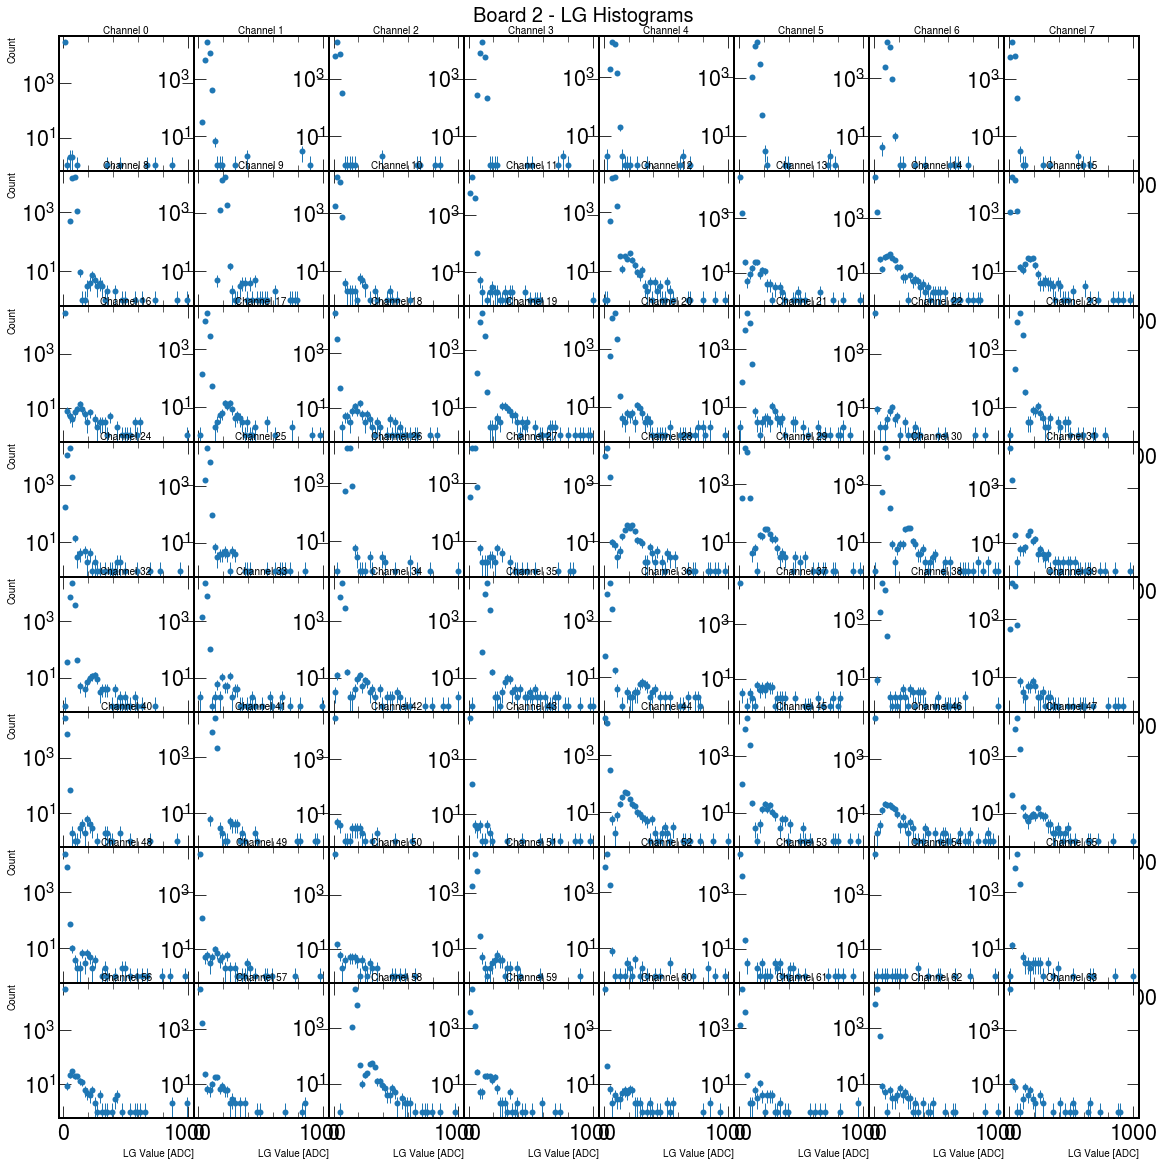

In [36]:
board_number = 2
ptrigs0 = plot_histograms_ptrig(board_number, events)
#board_number = 1
#ptrigs1 = plot_histograms_ptrig(board_number, events)
#board_number = 2
#ptrigs2 = plot_histograms_ptrig(board_number, events)


44.37680175680685


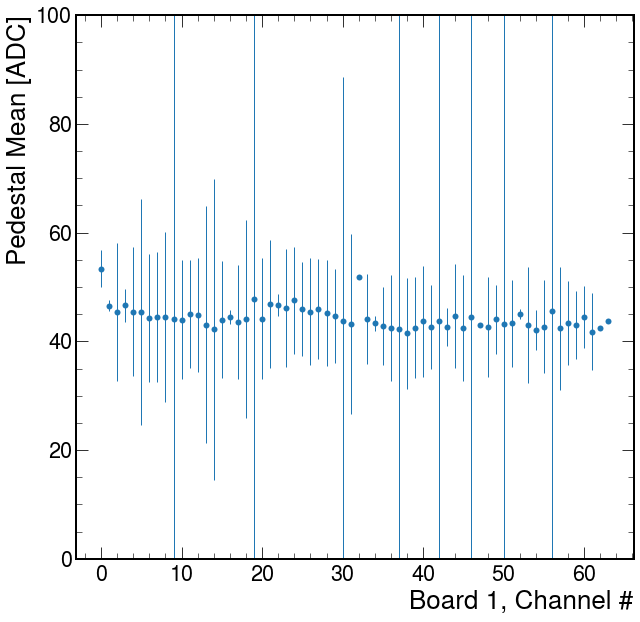

In [22]:
plt.errorbar(range(0,64), ptrigs0[0], yerr=ptrigs2[1], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

plt.ylim(0,100)
plt.xlabel("Board 1, Channel #")
plt.ylabel("Pedestal Mean [ADC]")
print(np.mean(ptrigs0[0]))

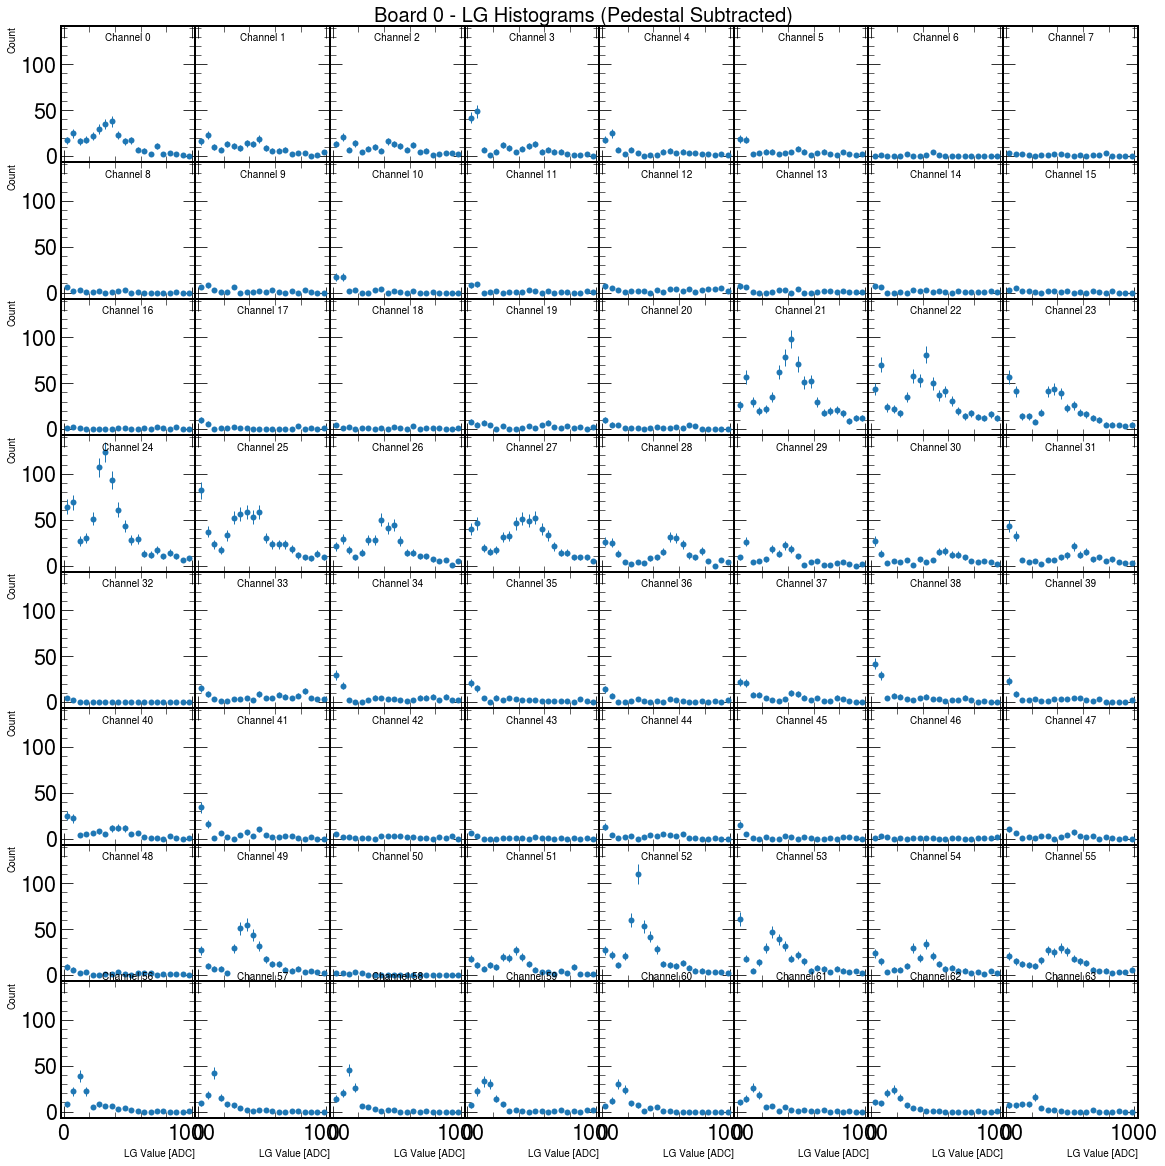

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/spreins/o

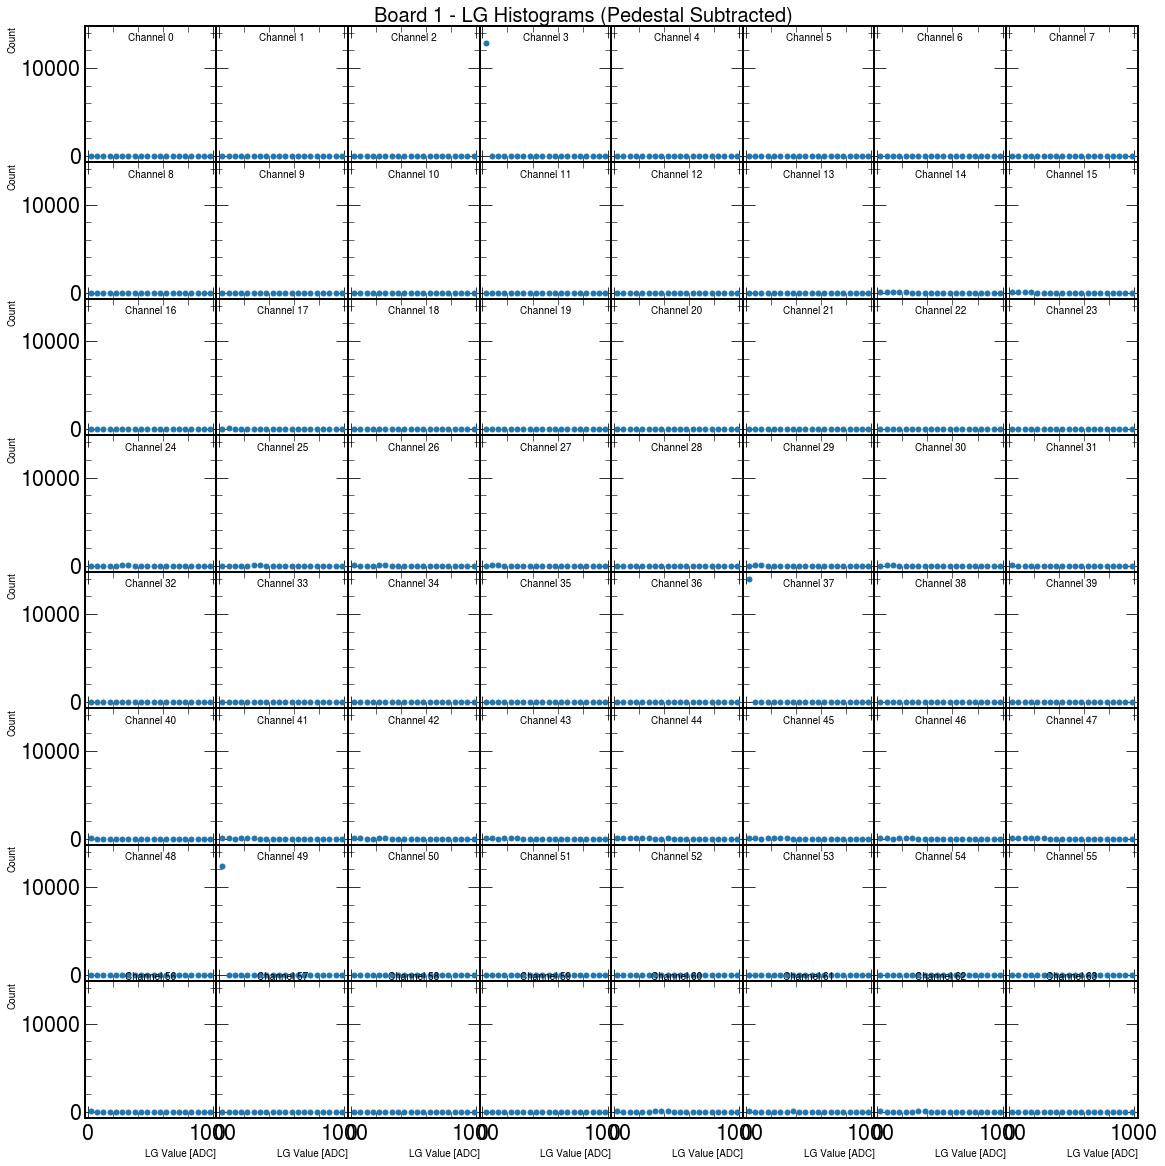

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/spreins/o

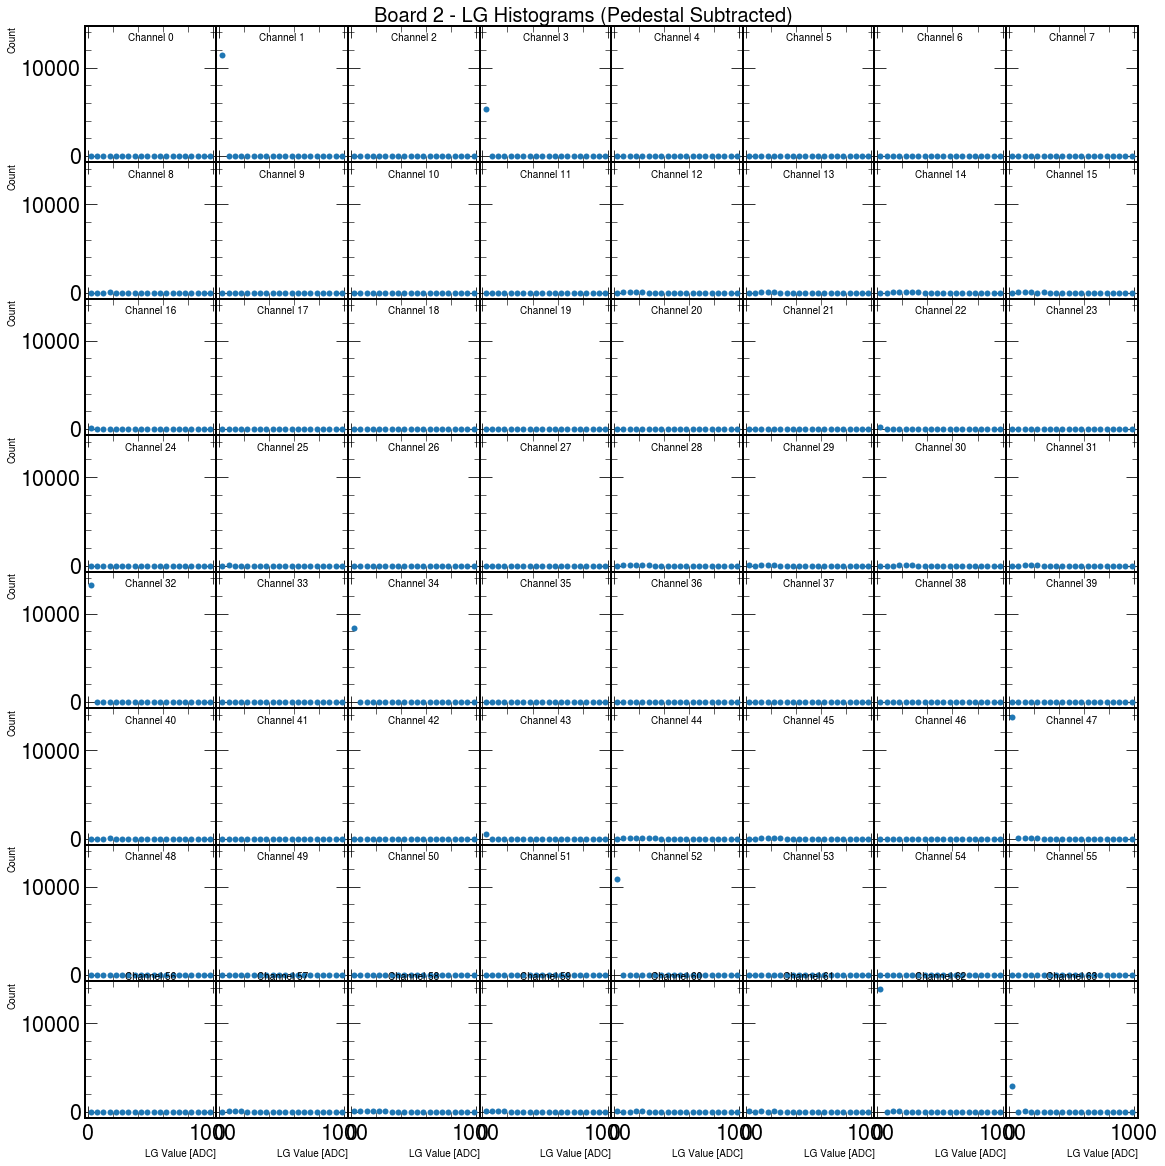

In [23]:
MIPs0 = plot_histograms_pedsub(0, events, ptrigs0)
MIPs1 = plot_histograms_pedsub(1, events, ptrigs1)
MIPs2 = plot_histograms_pedsub(2, events, ptrigs2)

Text(0, 1, 'MIP Mean [ADC]')

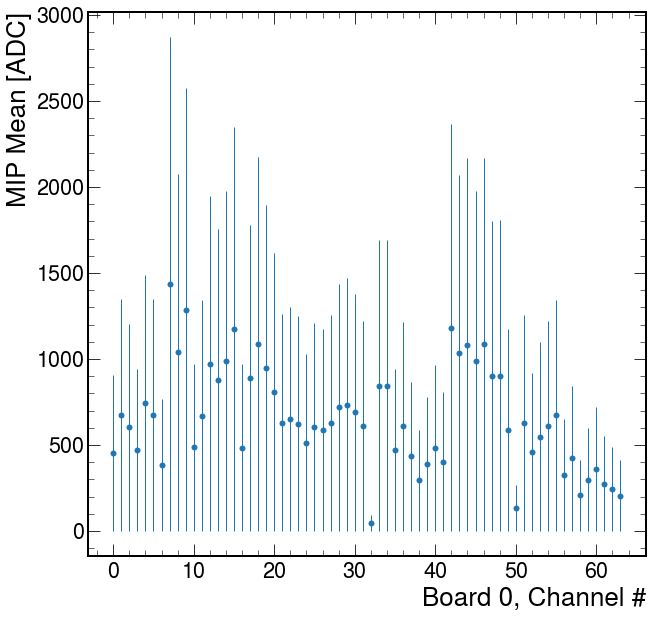

In [25]:
plt.errorbar(range(0,64), MIPs0[0], yerr=MIPs0[0], fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

#plt.ylim(0,100)
plt.xlabel("Board 0, Channel #")
plt.ylabel("MIP Mean [ADC]")